# Visualización de Precios de Propiedades en Buenos Aires

En este notebook se visualizan los precios de propiedades por barrio en la Ciudad de Buenos Aires y se grafican las ubicaciones de las propiedades sobre el mapa de la ciudad.

## 1. Cargar el Dataset Limpio de Buenos Aires

Se carga el DataFrame limpio que contiene las propiedades de la Ciudad de Buenos Aires. Nos aseguramos de que estén disponibles las columnas `barrio`, `precios_nuevos` (o `price_clean`), y `geometry`.

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Cargar el dataset limpio (con geometría) de Buenos Aires
# Si tienes el archivo GeoJSON exportado, puedes usarlo directamente.
# Si no, puedes cargar el CSV y luego reconstruir la geometría si tienes columnas 'lat' y 'lon'.

# Intentamos cargar el GeoDataFrame con geometría
try:
    properatti_bsas = gpd.read_file("tp2_properati_no_input.csv")
except Exception as e:
    # Si no existe el GeoJSON, cargar el CSV y reconstruir la geometría
    df = pd.read_csv("tp2_properati_no_input.csv")
    if 'lat' in df.columns and 'lon' in df.columns:
        geometry = gpd.points_from_xy(df['lon'], df['lat'])
        properatti_bsas = gpd.GeoDataFrame(df, geometry=geometry)
    else:
        raise RuntimeError("No se encontró información de geometría en el dataset.")

# Convertir 'price_usd_per_m2' a numérico y luego a enteros
if 'price_usd_per_m2' in properatti_bsas.columns:
    properatti_bsas['price_usd_per_m2'] = pd.to_numeric(properatti_bsas['price_usd_per_m2'], errors='coerce').round(0).astype('Int64')

# Filtrar solo las filas con barrio y precio válido
properatti_bsas = properatti_bsas[
    (properatti_bsas['barrio'].notnull()) & 
    (properatti_bsas['precios_nuevos'].notnull())
]
properatti_bsas.head()

,field_1,barrio,price_usd_per_m2,surface_total_clean,rooms_clean,precios_nuevos,precios_aprox_usd_clean,amenities,estacionamiento,sum,pileta,parrilla,gimnasio,lavadero,solarium,quincho,baulera,terraza,geometry
0,0,Mataderos,1127,55.0,2.0,62000.0,62000.0,True,False,False,False,False,False,True,False,False,False,True,None
1,2,Mataderos,1309,55.0,2.0,72000.0,72000.0,True,False,False,False,False,False,True,False,False,False,False,None
2,3,Liniers,<NA>,,3.0,95000.0,95000.0,False,False,False,False,False,False,False,False,False,False,True,None
3,7,Belgrano,3067,45.0,1.0,138000.0,138000.0,True,False,False,True,False,False,True,True,False,False,False,None
4,8,Belgrano,3000,65.0,2.0,195000.0,195000.0,True,False,False,True,False,False,True,True,False,False,False,None


## 2. Histograma/Boxplot de Precios de Propiedades por Barrio

Se grafican los precios de las propiedades agrupados por barrio. Para una mejor visualización, se pueden mostrar solo los barrios con suficiente cantidad de datos.

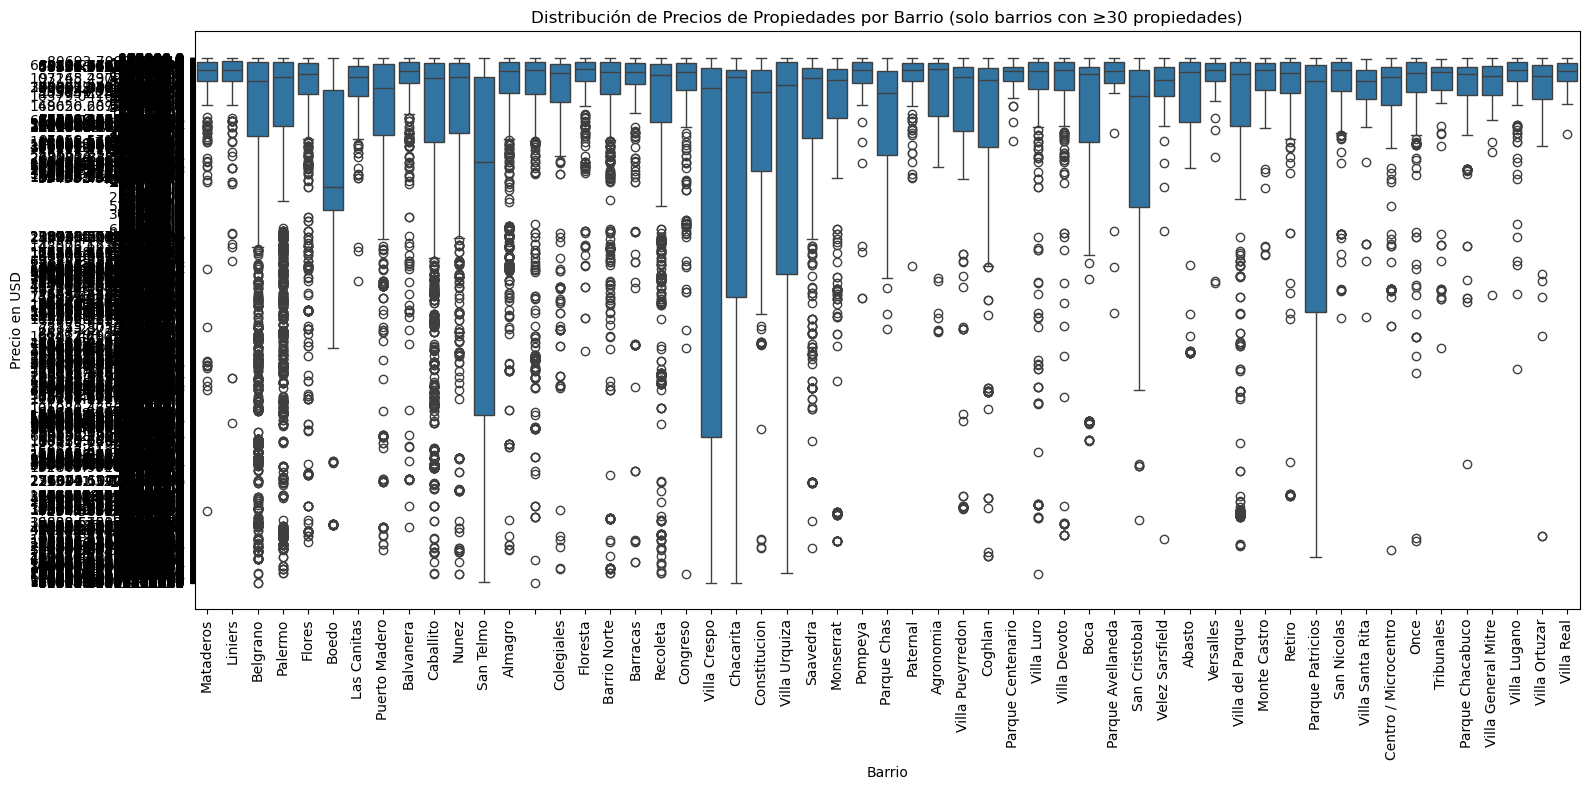

In [21]:
# Contar cantidad de propiedades por barrio
barrio_counts = properatti_bsas['barrio'].value_counts()
# Filtrar barrios con al menos 30 propiedades
barrios_filtrados = barrio_counts[barrio_counts >= 30].index
df_plot = properatti_bsas[properatti_bsas['barrio'].isin(barrios_filtrados)]

plt.figure(figsize=(16, 8))
sns.boxplot(data=df_plot, x='barrio', y='precios_nuevos')
plt.xticks(rotation=90)
plt.title('Distribución de Precios de Propiedades por Barrio (solo barrios con ≥30 propiedades)')
plt.xlabel('Barrio')
plt.ylabel('Precio en USD')
plt.tight_layout()
plt.show()

## 3. Cargar el Mapa de la Ciudad de Buenos Aires

Se carga el shapefile o GeoJSON correspondiente a la Ciudad de Buenos Aires. Si tienes un shapefile de provincias, se filtra la geometría de la ciudad.

## 4. Graficar las Propiedades sobre el Mapa de Buenos Aires

Se grafican los puntos de las propiedades sobre el mapa de la Ciudad de Buenos Aires.

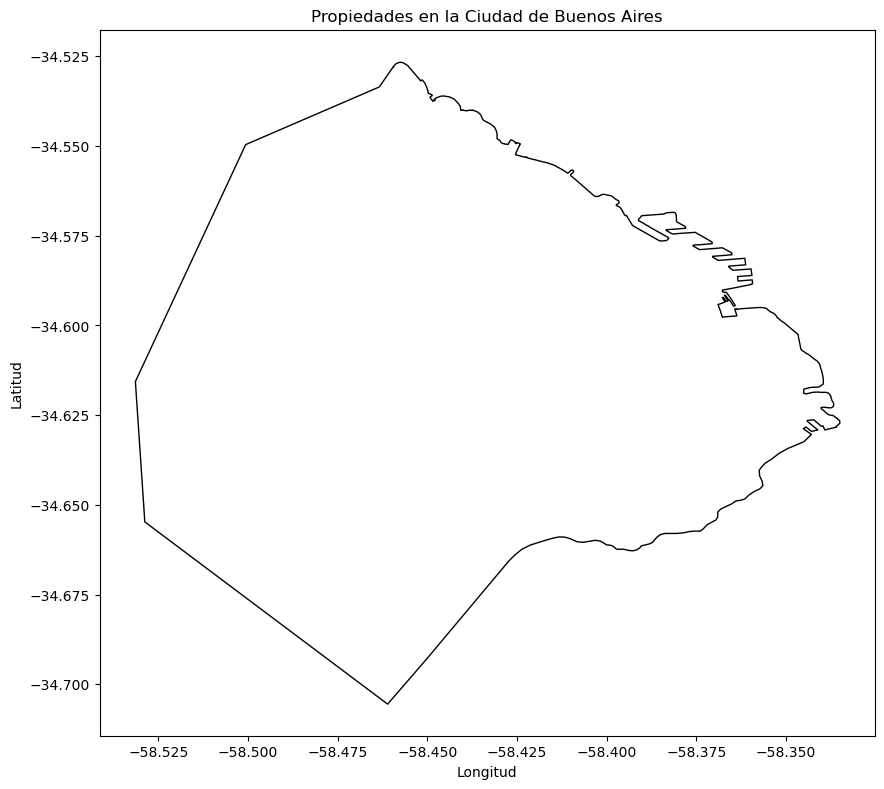

In [ ]:
# Cargar el shapefile de la Ciudad de Buenos Aires (CABA)
# Cambia la ruta si tu archivo está en otra carpeta o formato
caba_shape = gpd.read_file("provincias/provincia.shp")
# Filtrar solo la geometría de CABA (puede llamarse 'Ciudad Autónoma de Buenos Aires' o similar)
caba_shape = caba_shape[caba_shape['fna'].str.contains("Buenos Aires", case=False) & caba_shape['fna'].str.contains("Ciudad", case=False)]


fig, ax = plt.subplots(figsize=(10, 10))
caba_shape.plot(ax=ax, color='white', edgecolor='black')
properatti_bsas.plot(ax=ax, color='red', markersize=2, alpha=0.5)
plt.title("Propiedades en la Ciudad de Buenos Aires")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


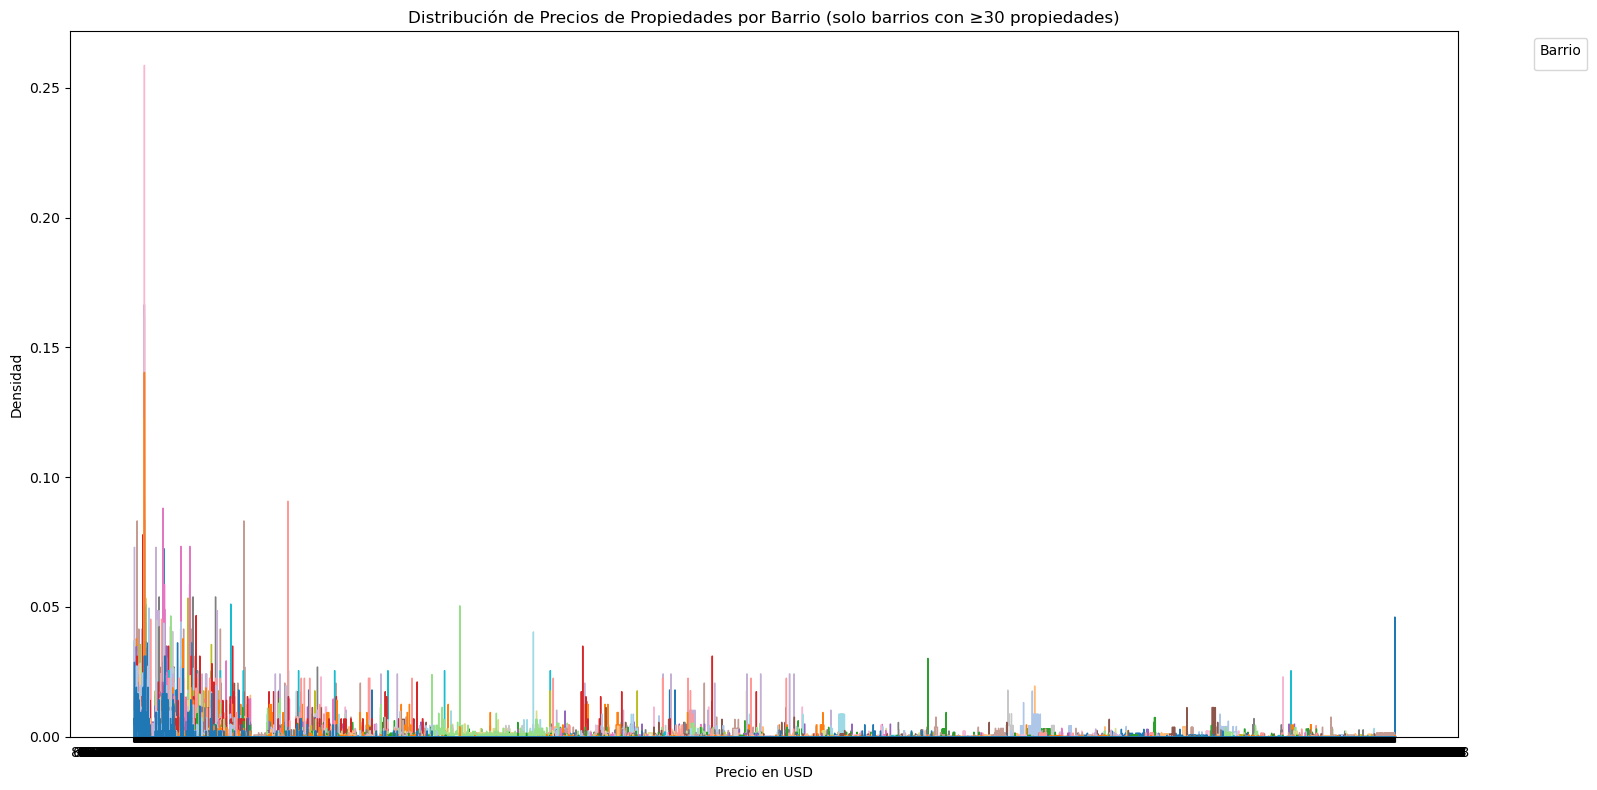

In [22]:

plt.figure(figsize=(16, 8))
barrios_filtrados = properatti_bsas['barrio'].value_counts()[properatti_bsas['barrio'].value_counts() >= 30].index
df_plot = properatti_bsas[properatti_bsas['barrio'].isin(barrios_filtrados)]

sns.histplot(
    data=df_plot,
    x='precios_nuevos',
    hue='barrio',
    element='step',
    stat='density',
    common_norm=False,
    bins=40,
    palette='tab20',
    alpha=0.5
)
plt.title('Distribución de Precios de Propiedades por Barrio (solo barrios con ≥30 propiedades)')
plt.xlabel('Precio en USD')
plt.ylabel('Densidad')
plt.legend(title='Barrio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

Con esto se visualizan tanto la distribución de precios por barrio como la ubicación geográfica de las propiedades en la Ciudad de Buenos Aires.

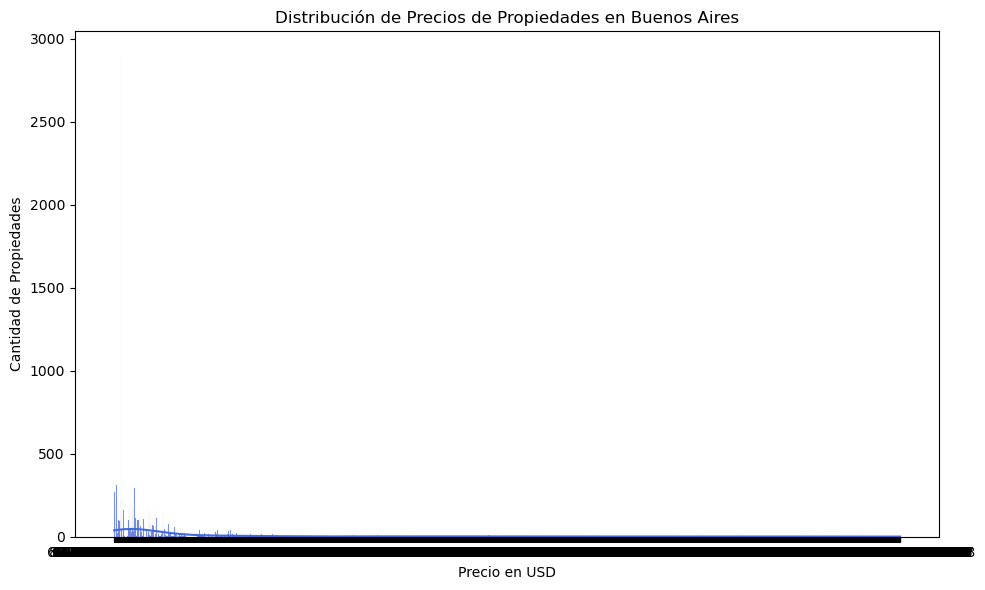

In [23]:
# Distribución de precios de todas las propiedades (sin agrupar por barrio)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=properatti_bsas,
    x='precios_nuevos',
    bins=40,
    kde=True,
    color='royalblue',
    alpha=0.7
)
plt.title('Distribución de Precios de Propiedades en Buenos Aires')
plt.xlabel('Precio en USD')
plt.ylabel('Cantidad de Propiedades')
plt.tight_layout()
plt.show()